In [1]:
import json
from shapely.geometry import shape, Point
from matplotlib.lines import Line2D
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib.request
import simplejson
from cluster_model import ClusterModel
from datetime import timedelta
import pickle
import seaborn as sns
import networkx as nx

In [2]:
# use correct path to the geojson file
with open("/Users/Timothy/Documents/CSUREMM-main/new-york-city-boroughs.geojson") as f:
    boroughs_geojson = json.load(f)

def classify_borough(lat, lon, boroughs_geojson):
    point = Point(lon, lat)
    for feature in boroughs_geojson['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['name']  # or appropriate property name
    return 'Unknown'

In [3]:
# this may take a minute...
with open('/Users/Timothy/Documents/CSUREMM-main/data/data.pickle', 'rb') as f:
    station_data = pickle.load(f)

cluster_model = ClusterModel(station_data=station_data, in_transit=[], tph=4)
horizontal_squares, vertical_squares, clusters = cluster_model.cluster_stations(0.005)
cluster_model.init_clusters()
cluster_model.init_state(path='/Users/Timothy/Documents/CSUREMM-main/data/station_data/status_at_time/2024_6_20_2:19.csv',
                         time=timedelta(hours=23))

boro_dict = {}
for cluster in cluster_model.cluster_dict.values():
    boro_dict[cluster.name] = classify_borough(cluster.lat, cluster.lon, boroughs_geojson)

36 horizontal squares and 51 vertical squares. Total squares: 1836


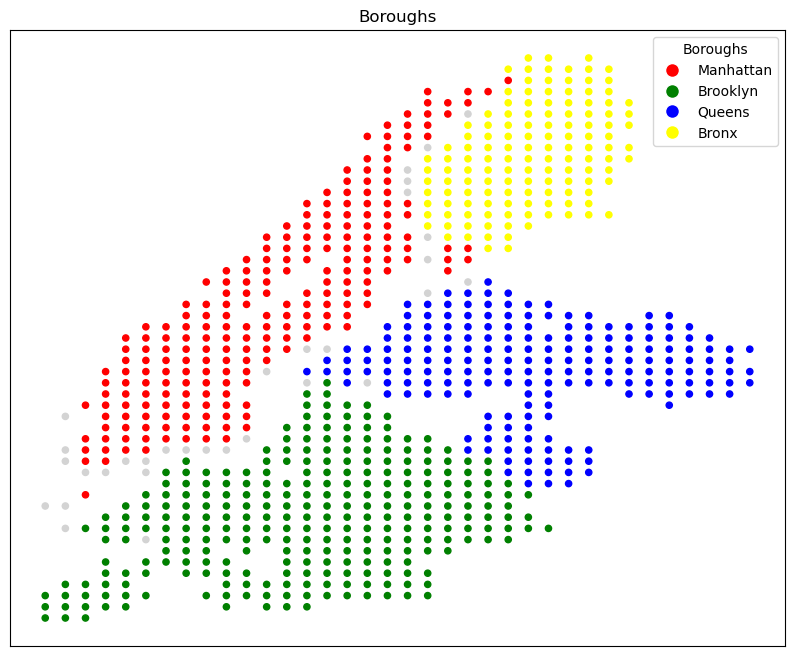

In [4]:
color_map = {'Manhattan': 'red', 'Brooklyn': 'green', 'Queens': 'blue', 'Bronx': 'yellow'}

G = nx.DiGraph()

positions = {}
node_colors = []

for cluster in cluster_model.cluster_dict.values():
    positions[cluster] = (cluster.lon, cluster.lat)
    G.add_node(cluster)
    borough = boro_dict.get(cluster.name, 'Unknown')
    node_colors.append(color_map.get(borough, 'lightgray'))  # Default to 'lightgray' if borough not found

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, positions, node_size=20, node_color=node_colors)
legend_elements = [Line2D([0], [0], marker='o', color='w', label=borough, markersize=10, markerfacecolor=color) 
                   for borough, color in color_map.items()]
plt.legend(handles=legend_elements, title="Boroughs")
plt.title("Boroughs")
plt.show()